In [1]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

import argparse as ap

def recompute_hard_labels(soft_labels):
    """optionally, infer hard labels from the soft labels provided"""
    hard_labels = [] 
    prev_end = -1
    for start, end in (
        (lbl['start'], lbl['end']) 
        for lbl in sorted(soft_labels, key=lambda span: (span['start'], span['end']))
        if lbl['prob'] > 0.5
    ):
        if start == prev_end:
            hard_labels[-1][-1] = end
        else:
            hard_labels.append([start, end])
        prev_end = end
    return hard_labels


def infer_soft_labels(hard_labels):
    """reformat hard labels into soft labels with prob 1"""
    return [
        {
            'start': start,
            'end': end,
            'prob': 1.0,
        }
        for start, end in hard_labels
    ]

def load_jsonl_file_to_records(filename, is_ref=True):
    """read data from a JSONL file and format that as a `pandas.DataFrame`.
    Performs minor format checks (ensures that some labels are present,
    optionally compute missing labels on the fly)."""
    df = pd.read_json(filename, lines=True)
    if not is_ref:
        assert ('hard_labels' in df.columns) or ('soft_labels' in df.columns), \
            f'File {filename} contains no predicted label!'
        if 'hard_labels' not in df.columns:
            df['hard_labels'] = df.soft_labels.apply(recompute_hard_labels)
        elif 'soft_labels' not in df.columns:
            df['soft_labels'] = df.hard_labels.apply(infer_soft_labels)
    # adding an extra column for convenience
    columns = ['id', 'soft_labels', 'hard_labels']
    if is_ref:
        df['text_len'] = df.model_output_text.apply(len)
        columns += ['text_len']
    df = df[columns]
    return df.sort_values('id').to_dict(orient='records')

import numpy as np

def convert_probs_to_array(probs, dim):
    array = np.zeros(dim)
    
    for prob in probs:
        start = prob['start']
        end = prob['end']
        prob = prob['prob']
        
        array[start:end] = prob
    
    return array

In [2]:
def calculate_soft_labels(words, hallucination_scores, theta = 1):
    soft_labels = []
    
    # Initialize the starting position of the first word
    start_position = 0

    for word, score in zip(words, hallucination_scores):
        word_length = len(word)
        
        # Calculate the ending position
        end_position = start_position + word_length
        
        # Append the soft label entry
        soft_labels.append({
            "start": start_position,
            "prob": score * theta,
            "end": end_position
        })
        
        # Update the starting position for the next word (accounting for space)
        start_position = end_position + 1  # Add 2 for the space between words

    return soft_labels

# Example usage
data = {
    "words evaluated": [" ", "No,", "Albero", "Foulois", "was", "not", "in", "any", "of", "the", "FIFA", "World", "Cup", "finals.\n"],
    "hallucination_scores_evaluated": [0, 1.0, 0.06837508948018978, 0.9810742402775567, 0.5219719747190859, 0.8440420620456921, 0.039483340157654756, 0.7283849860862854, 0.0, 0.12374613816374336, 0.9193932406560029, 0.0, 0.0, 0.0]
}

soft_labels = calculate_soft_labels(data["words evaluated"], data["hallucination_scores_evaluated"], theta=0.5)

# Output the result
print(soft_labels)

hard_labels = recompute_hard_labels(soft_labels)
print(hard_labels)


[{'start': 0, 'prob': 0.0, 'end': 1}, {'start': 2, 'prob': 0.5, 'end': 5}, {'start': 6, 'prob': 0.03418754474009489, 'end': 12}, {'start': 13, 'prob': 0.49053712013877837, 'end': 20}, {'start': 21, 'prob': 0.2609859873595429, 'end': 24}, {'start': 25, 'prob': 0.42202103102284605, 'end': 28}, {'start': 29, 'prob': 0.019741670078827378, 'end': 31}, {'start': 32, 'prob': 0.3641924930431427, 'end': 35}, {'start': 36, 'prob': 0.0, 'end': 38}, {'start': 39, 'prob': 0.06187306908187168, 'end': 42}, {'start': 43, 'prob': 0.45969662032800146, 'end': 47}, {'start': 48, 'prob': 0.0, 'end': 53}, {'start': 54, 'prob': 0.0, 'end': 57}, {'start': 58, 'prob': 0.0, 'end': 66}]
[]


# Generation of soft and hard labels

In [ ]:
import json 
import os

data_dir = "data/test"
output_path = os.path.join(data_dir, "results_full.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_data = [json.loads(line) for line in f]

In [ ]:
len(processed_data[1]['results']), len(processed_data[1]['words_evaluated'])

In [ ]:
import json 
import os

# data_dir = "data/test"
# output_path = os.path.join(data_dir, "results_mult.jsonl")
# if os.path.exists(output_path):
#     with open(output_path, "r") as f:
#         processed_data = [json.loads(line) for line in f]
result_path = os.path.join(data_dir, "final_results.jsonl")

for entry in processed_data: 
    try:
        words_evaluated = entry['words evaluated']
        hallucination_scores_evaluated = entry['hallucination_scores_evaluated']
    except:
        words_evaluated = entry['hallucination_scores_evaluated'][0]
        hallucination_scores_evaluated = entry['hallucination_scores_evaluated'][1]
    
    # if the first element of the words evaluated is "", then remove it and the corresponding hallucination score
    if words_evaluated[0] == "":
        words_evaluated[0] = " "
        hallucination_scores_evaluated[0] = 0
    
    soft_labels = calculate_soft_labels(words_evaluated, hallucination_scores_evaluated)
    hard_labels = recompute_hard_labels(soft_labels)

    # save the hard labels to the processed data
    entry['hard_labels'] = hard_labels
    entry['soft_labels'] = soft_labels

    # save the processed data to the new file
    with open(result_path, "w") as f:
        for entry in processed_data:
            f.write(json.dumps(entry) + "\n")
        
    assert len(words_evaluated) == len(hallucination_scores_evaluated)
    

# MNLI on full sentence dataset

In [ ]:
import os
import json

data_dir = "data/test"
output_path = os.path.join(data_dir, "Qwen2-0.5B-Instruct_evaluated.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_data = [json.loads(line) for line in f]

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

def get_mnli_probs(sentence_1, sentence_2, model, tokenizer, word_evaluated, device = "cpu"):
    # if the two sentences are longer than the maximum length, cut them around a defined word 

    inputs = tokenizer(sentence_1, sentence_2, return_tensors="pt").to(device)
    max_length = 512
    if len(inputs.input_ids[0]) > max_length:
        input_1 = mnli_tokenizer(sentence_1, return_tensors="pt").to(device)
        input_2 = mnli_tokenizer(sentence_2, return_tensors="pt").to(device)
        word_tokenized = mnli_tokenizer.encode(word_evaluated)[1]
        for i, token in enumerate(inputs.input_ids[0]):
            if token == word_tokenized:
                token_position = i
                break

        # cut the sentences around the word
        half_length = max_length // 2
        start = max(0, token_position - half_length)
        end = min(len(inputs.input_ids[0]), token_position + half_length)

        input_1 = input_1.input_ids[0][start:end]
        input_2 = input_2.input_ids[0][start:end]
        input_1_decoded = mnli_tokenizer.decode(input_1, skip_special_tokens=True)
        input_2_decoded = mnli_tokenizer.decode(input_2, skip_special_tokens=True)
        inputs = mnli_tokenizer(input_1_decoded, input_2_decoded, return_tensors="pt").to(device)

    outputs = model(**inputs)
    predicted_class_prob = outputs.logits.softmax(dim=1)
    return predicted_class_prob

device = "cuda"

mnli_model = AutoModelForSequenceClassification.from_pretrained("cross-encoder/nli-deberta-v3-large").to(device)
mnli_tokenizer = AutoTokenizer.from_pretrained("cross-encoder/nli-deberta-v3-large")

In [ ]:
from tqdm import tqdm
for sample in tqdm(processed_data):
    try: 
        device = "cuda"
        mnli_model = mnli_model.to(device)
        gold_sentence = sample['model_output_text']
        for i, results in enumerate(sample['results']):
            word_to_replace = sample['words_evaluated'][i]
            for result in results: 
                word = result['full_word']
                output_sentence = gold_sentence.replace(word_to_replace, word)
                prob = get_mnli_probs(gold_sentence, output_sentence, mnli_model, mnli_tokenizer, word_to_replace, device).tolist()
                result['sentence_mnli_prob'] = prob
            torch.cuda.empty_cache()
    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print(e)
            torch.cuda.empty_cache()
            device = "cpu"
            mnli_model = mnli_model.to(device)
            gold_sentence = sample['model_output_text']
            for i, results in enumerate(sample['results']):
                word_to_replace = sample['words_evaluated'][i]
                for result in results: 
                    word = result['full_word']
                    output_sentence = gold_sentence.replace(word_to_replace, word)
                    prob = get_mnli_probs(gold_sentence, output_sentence, mnli_model, mnli_tokenizer, device).tolist()
                    result['sentence_mnli_prob'] = prob
            else: 
                raise e



In [ ]:
# save the processed data to the new file
result_path = os.path.join(data_dir, "Qwen2-0.5B-Instruct_evaluated_full_sentence.jsonl")
with open(result_path, "w") as f:
    for entry in processed_data:
        f.write(json.dumps(entry) + "\n")

In [ ]:
sample['results'][5]

# Treshold evaluation on val dataset

In [3]:
import os
import json

data_dir = "data/val"
output_path = os.path.join(data_dir, "results_full_sentence.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_data = [json.loads(line) for line in f]

In [4]:
processed_data[0].keys()

dict_keys(['id', 'lang', 'model_input', 'model_output_text', 'model_id', 'soft_labels', 'hard_labels', 'model_output_logits', 'model_output_tokens', 'words_evaluated', 'results'])

In [5]:
gold = convert_probs_to_array(processed_data[0]['soft_labels'], len(processed_data[0]['model_output_text']))
gold

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.2, 0.3,
       0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 0.3, 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
       0.2, 0.2, 0.2, 0.2, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0. ])

In [6]:
for entry in processed_data:
    assert len(entry['words_evaluated']) == len(entry['results'])

res = processed_data[0]['results']

In [7]:
'''
"id2label": {
    "0": "contradiction",
    "1": "entailment",
    "2": "neutral"
  },
'''

'\n"id2label": {\n    "0": "contradiction",\n    "1": "entailment",\n    "2": "neutral"\n  },\n'

In [8]:
import torch
soft_labels_per_word = []
for i, res in enumerate(processed_data[0]['results']):
    print("Word evaluated: ", processed_data[0]['words_evaluated'][i])
    p_plus = [prob['sentence_mnli_prob'][0][1] + prob['sentence_mnli_prob'][0][2] for prob in res]
    # softmax = [torch.tensor(prob['sentence_mnli_prob'][0]).softmax(dim=0).argmax().item() for prob in res]
    # p_plus = [1 if prob == 1 else 0 for prob in softmax]
    #p_plus = [prob['sentence_mnli_prob'][0][1] for prob in word]
    p_i = np.array(p_i)
    p_plus = np.array(p_plus)
    hallucination_score = 1 - (sum(p_i * p_plus) / sum(p_i))
    print("Hallucination score: ", hallucination_score)
    soft_labels_per_word.append(hallucination_score)

res_obtained = calculate_soft_labels(processed_data[0]["words_evaluated"], soft_labels_per_word)

Word evaluated:  Petra


NameError: name 'p_i' is not defined

In [ ]:
processed_data[0]["model_output_text"]

In [ ]:
gold = convert_probs_to_array(processed_data[0]['soft_labels'], len(processed_data[0]['model_output_text']))
gold

In [9]:
import torch

target = []
output = []

for entry in processed_data:
    res = entry['results']
    soft_labels_per_word = []
    for word in res: 
        p_i = [prob['token_prob'] for prob in word]
        p_plus = [prob['sentence_mnli_prob'][0][1] + prob['sentence_mnli_prob'][0][2] for prob in word]
        # softmax = [torch.tensor(prob['sentence_mnli_prob'][0]).softmax(dim=0).argmax().item() for prob in word]
        # p_plus = [1 if prob == 1 else 0 for prob in softmax]
        #p_plus = [prob['sentence_mnli_prob'][0][1] for prob in word]
        p_i = np.array(p_i)
        p_plus = np.array(p_plus)
        hallucination_score = 1 - (sum(p_i * p_plus) / sum(p_i))
        hallucination_score = hallucination_score * 1
        soft_labels_per_word.append(hallucination_score)

    soft_labels = calculate_soft_labels(entry['words_evaluated'], soft_labels_per_word)
    res_obtained = convert_probs_to_array(soft_labels, len(entry['model_output_text']))
    gold = convert_probs_to_array(entry['soft_labels'], len(entry['model_output_text']))
    target.append(gold)
    output.append(res_obtained)

print(len(target), len(output))   

49 49


In [10]:
def iou_evaluator(target, output):
    temp_target = np.array([1 if t > 0.5 else 0 for t in target])
    temp_output = np.array([1 if o > 0.5 else 0 for o in output])
    
    overlap = temp_target * temp_output
    union = temp_target + temp_output

    return overlap.sum()/float(union.sum()+1e-6)

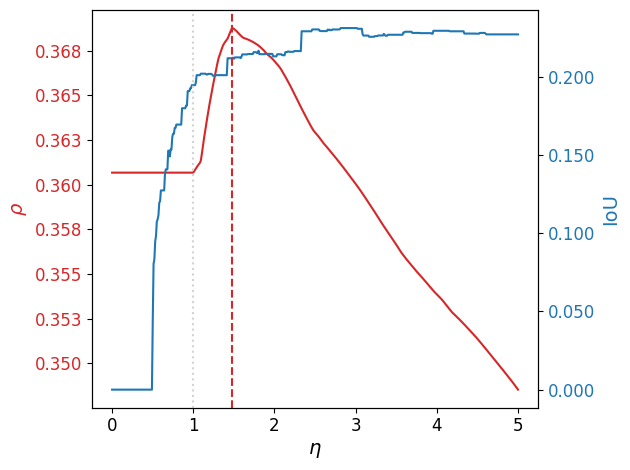

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

font_dim = 14
tick_fontsize = 12  # Definisci la dimensione del font per i numeri delle scale

# make an optimization problem to find the best theta that minimize the mse
thetas = np.linspace(0.001, 5, 500)
mses = []
ious = []
for theta in thetas:
    temp = []
    temp_iou = []
    for i in range(len(output)):
        res = output[i] * theta
        # cap the values to 1
        res = np.minimum(res, 1)

        correlation, _ = pearsonr(res, target[i])
        iou = iou_evaluator(target[i], res)

        temp.append(np.mean(correlation))
        temp_iou.append(np.mean(iou))

    mses.append(np.mean(temp))
    ious.append(np.mean(temp_iou))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'$\eta$', fontsize=font_dim)  # Usa LaTeX per epsilon greca e aumenta la dimensione del testo
ax1.set_ylabel(r'$\rho$', color=color, fontsize=font_dim)  # Aumenta la dimensione del testo
ax1.plot(thetas, mses, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)  # Aumenta la dimensione dei numeri delle scale
ax1.tick_params(axis='x', labelsize=tick_fontsize)  # Aumenta la dimensione dei numeri delle scale
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('IoU', color=color, fontsize=font_dim)  # Aumenta la dimensione del testo
ax2.plot(thetas, ious, color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)  # Aumenta la dimensione dei numeri delle scale
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))  # Formatta i numeri a due cifre significative

plt.axvline(x=1, linestyle=':', color='lightgray')
plt.axvline(x=thetas[np.argmax(mses)], linestyle='--', color='tab:red')

fig.tight_layout()
max = mses.index(np.max(mses))
# plt.title(f'best theta {thetas[max]:.2f}, iou {ious[max]:.2f}, corr {mses[max]:.2f}')

# Salva il grafico come file PDF
plt.savefig('grafico.pdf', format='pdf')

plt.show()

In [12]:
len(ious), len(mses), len(thetas)

(500, 500, 500)

In [18]:
res = {"etas": thetas, "rho": mses, "ious": ious}

# save pickle 
import pickle

with open("results.pkl", "wb") as f:
    pickle.dump(res, f)

with open("results.pkl", "rb") as f:
    res = pickle.load(f)

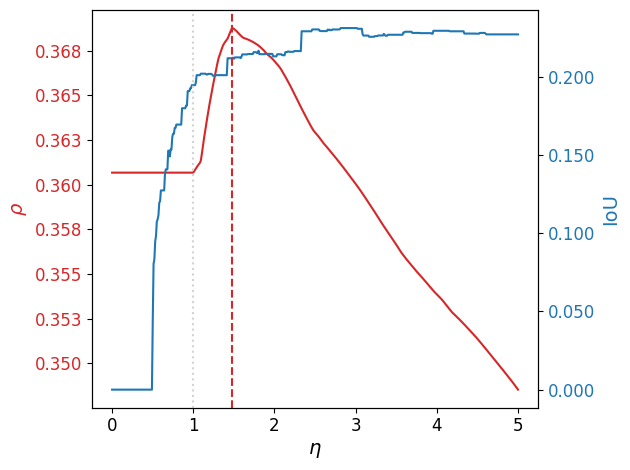

In [20]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel(r'$\eta$', fontsize=font_dim)  
ax1.set_ylabel(r'$\rho$', color=color, fontsize=font_dim)  
ax1.plot(res['etas'], res['rho'], color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)  
ax1.tick_params(axis='x', labelsize=tick_fontsize)  
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('IoU', color=color, fontsize=font_dim)  
ax2.plot(res['etas'], res['ious'], color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=tick_fontsize)  
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))  

plt.axvline(x=1, linestyle=':', color='lightgray')
plt.axvline(x=res['etas'][np.argmax(res['rho'])], linestyle='--', color='tab:red')

fig.tight_layout()
max = res['rho'].index(np.max(res['rho']))

plt.savefig('fig.pdf', format='pdf')

plt.show()

In [ ]:
a = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
b = np.array([0.1, 0.2, 0.2, 0.2, 0.5, 0.5]) * 10

pearsonr(a,b)

In [ ]:
output = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
theta_matrix = np.ones_like(output) * 0.5
theta_matrix = 2
theta_matrix * output

In [ ]:
# print theta at 1 
mses[100]

# Submission

In [ ]:
import os
import json

data_dir = "data/test"
output_path = os.path.join(data_dir, "Qwen2-0.5B-Instruct_evaluated_full_sentence.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        processed_data = [json.loads(line) for line in f]



In [ ]:
# RESULT GENERATION 
import torch
import numpy as np

for entry in processed_data:
    res = entry['results']
    soft_labels_per_word = []
    for word in res: 
        p_i = [prob['token_prob'] for prob in word]
        p_plus = [prob['sentence_mnli_prob'][0][1] + prob['sentence_mnli_prob'][0][2] for prob in word]
        #p_plus = [prob['sentence_mnli_prob'][0][1] for prob in word]
        # softmax = [torch.tensor(prob['sentence_mnli_prob'][0]).softmax(dim=0).argmax().item() for prob in word]
        # p_plus = [1 if prob == 1 else 0 for prob in softmax]
        #p_plus = [prob['sentence_mnli_prob'][0][1] for prob in word]
        p_i = np.array(p_i)
        p_plus = np.array(p_plus)
        hallucination_score = 1 - (sum(p_i * p_plus) / sum(p_i))
        hallucination_score = hallucination_score
        # cap at 1 
        hallucination_score = min(hallucination_score, 1)
        soft_labels_per_word.append(hallucination_score)

    soft_labels = calculate_soft_labels(entry['words_evaluated'], soft_labels_per_word)
    res_obtained = convert_probs_to_array(soft_labels, len(entry['model_output_text']))
    # remove soft labels entry if start_position == end_position
    soft_labels = [label for label in soft_labels if label['start'] != label['end']]
    entry['soft_labels'] = soft_labels

    hard_labels = recompute_hard_labels(soft_labels)
    entry['hard_labels'] = hard_labels

# save submission 
result_path = os.path.join(data_dir, "paper_results_Qwen2-0.5B.jsonl")
with open(result_path, "w") as f:
    for entry in processed_data:
        f.write(json.dumps(entry) + "\n")

In [ ]:
res = processed_data[0]['results'][0]
len(res)

for word in res: 
    # take nli label 
    nli_label = torch.tensor(word['sentence_mnli_prob'][0]).softmax(dim=0).argmax().item()


In [ ]:
# RESULT GENERATION 
import torch
import numpy as np

for entry in processed_data:
    res = entry['results']
    soft_labels_per_word = []
    for word in res: 
        p_i = [prob['token_prob'] for prob in word]
        softmax = [torch.tensor(prob['sentence_mnli_prob'][0]).softmax(dim=0).argmax().item() for prob in word]
        p_plus = [1 if prob == 1 else 0 for prob in softmax]
        p_minus = [1 if prob == 0 else 0 for prob in softmax]
        p_i = np.array(p_i)
        p_plus = np.array(p_plus)
        hallucination_score = 1 - (sum(p_i * p_plus) / (sum(p_i * p_plus) + sum(p_i*p_minus) + 1e-6))
        hallucination_score = min(hallucination_score, 1)
        soft_labels_per_word.append(hallucination_score)

    soft_labels = calculate_soft_labels(entry['words_evaluated'], soft_labels_per_word)
    res_obtained = convert_probs_to_array(soft_labels, len(entry['model_output_text']))
    # remove soft labels entry if start_position == end_position
    soft_labels = [label for label in soft_labels if label['start'] != label['end']]
    entry['soft_labels'] = soft_labels

    hard_labels = recompute_hard_labels(soft_labels)
    entry['hard_labels'] = hard_labels

# save submission 
result_path = os.path.join(data_dir, "paper_results_rw.jsonl")
with open(result_path, "w") as f:
    for entry in processed_data:
        f.write(json.dumps(entry) + "\n")

In [ ]:
p_plus, p_minus

# Results for the paper 

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

import argparse as ap 

def score_iou(ref_dict, pred_dict):
    """computes intersection-over-union between reference and predicted hard labels, for a single datapoint.
    inputs:
    - ref_dict: a gold reference datapoint,
    - pred_dict: a model's prediction
    returns:
    the IoU, or 1.0 if neither the reference nor the prediction contain hallucinations
    """
    # ensure the prediction is correctly matched to its reference
    assert ref_dict['id'] == pred_dict['id']
    # convert annotations to sets of indices
    ref_indices = {idx for span in ref_dict['hard_labels'] for idx in range(*span)}
    pred_indices = {idx for span in pred_dict['hard_labels'] for idx in range(*span)}
    # avoid division by zero
    if not pred_indices and not ref_indices: return 1.
    # otherwise compute & return IoU
    return len(ref_indices & pred_indices) / len(ref_indices | pred_indices)

def score_cor(ref_dict, pred_dict):
    """computes Spearman correlation between predicted and reference soft labels, for a single datapoint.
    inputs:
    - ref_dict: a gold reference datapoint,
    - pred_dict: a model's prediction
    returns:
    the Spearman correlation, or a binarized exact match (0.0 or 1.0) if the reference or prediction contains no variation
    """
    # ensure the prediction is correctly matched to its reference
    assert ref_dict['id'] == pred_dict['id']
    # convert annotations to vectors of observations
    ref_vec = [0.] * ref_dict['text_len']
    pred_vec = [0.] * ref_dict['text_len']
    for span in ref_dict['soft_labels']:
        for idx in range(span['start'], span['end']):
            ref_vec[idx] = span['prob']
    for span in pred_dict['soft_labels']:
        for idx in range(span['start'], span['end']):
            pred_vec[idx] = span['prob']
    # constant series (i.e., no hallucination) => cor is undef
    if len({round(flt, 8) for flt in pred_vec}) == 1 or len({round(flt, 8) for flt in ref_vec}) == 1 : 
        return float(len({round(flt, 8) for flt in ref_vec}) == len({round(flt, 8) for flt in pred_vec}))
    # otherwise compute Spearman's rho
    return spearmanr(ref_vec, pred_vec).correlation

In [ ]:
# load submission file 
import os
import json

data_dir = "data/test"
output_path = os.path.join(data_dir, "paper_results_our_only_pos.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        our_result = [json.loads(line) for line in f]

data_dir = "data/test_labeled/v1"
output_path = os.path.join(data_dir, "mushroom.en-tst.v1.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        ground_truth = [json.loads(line) for line in f]


In [ ]:
our_result[0].keys()

In [ ]:
our_result[0]['soft_labels'][0]

In [ ]:
ground_truth[0]['soft_labels'][0]

In [ ]:
ground_truth[0].keys()

In [ ]:
assert len(ground_truth) == len(our_result)

ious = []
cors = []

for i in range(len(ground_truth)):
    id = ground_truth[i]['id']

    # look for the corresponding id in our result
    for j in range(len(our_result)):
        if our_result[j]['id'] == id:
            break

    ground_truth[i]['text_len'] = len(ground_truth[i]['model_output_text'])
    assert our_result[j]['id'] == id
    assert len(ground_truth[i]['model_output_text']) == len(our_result[j]['model_output_text'])

    iou = score_iou(ground_truth[i], our_result[j])
    cor = score_cor(ground_truth[i], our_result[j])

    ious.append(iou)
    cors.append(cor)

# print cor and iou

ious = np.array(ious)
cors = np.array(cors)
print(ious.mean(), cors.mean())

In [ ]:
ground_truth[0]['text_len'] = len(ground_truth[0]['model_output_text'])
score_cor(ground_truth[0], our_result[0])

# Qualitative Examples 

In [ ]:
# load submission file 
import os
import json

data_dir = "data/test"
output_path = os.path.join(data_dir, "paper_results_our_eta_1.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        our_result = [json.loads(line) for line in f]

data_dir = "data/test_labeled/v1"
output_path = os.path.join(data_dir, "mushroom.en-tst.v1.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        ground_truth = [json.loads(line) for line in f]


In [ ]:
ground_truth[0].keys()

In [ ]:
idx = 8
print(ground_truth[idx]['model_input'] + " " + ground_truth[idx]['model_output_text'])
print("GROUND TRUTH")
print(ground_truth[idx]['hard_labels'])


# print the hallucinated characters (from the hard labels, there is a list of lists in which each list contains the start and end of the hallucinated word)

for i in range(len(ground_truth[idx]['hard_labels'])):
    print(ground_truth[idx]['model_output_text'][ground_truth[idx]['hard_labels'][i][0]:ground_truth[idx]['hard_labels'][i][1]])

print("OUR RESULT")

print(our_result[idx]['hard_labels'])
for i in range(len(our_result[idx]['hard_labels'])):
    print(our_result[idx]['model_output_text'][our_result[idx]['hard_labels'][i][0]:our_result[idx]['hard_labels'][i][1]])

In [ ]:
idx = 36 #36
print(ground_truth[idx]['model_input'] + " " + ground_truth[idx]['model_output_text'])
print("GROUND TRUTH")
print(ground_truth[idx]['hard_labels'])


# print the hallucinated characters (from the hard labels, there is a list of lists in which each list contains the start and end of the hallucinated word)

for i in range(len(ground_truth[idx]['hard_labels'])):
    print(ground_truth[idx]['model_output_text'][ground_truth[idx]['hard_labels'][i][0]:ground_truth[idx]['hard_labels'][i][1]])

# look for our result with the same index 

for idx_2 in range(len(our_result)):
    if our_result[idx_2]['id'] == ground_truth[idx]['id']:
        break
print("OUR RESULT")
print(our_result[idx_2]['hard_labels'])
for i in range(len(our_result[idx_2]['hard_labels'])):
    print(our_result[idx_2]['model_output_text'][our_result[idx_2]['hard_labels'][i][0]:our_result[idx_2]['hard_labels'][i][1]])

In [ ]:
# load submission file 
import os
import json

data_dir = "data/test"
output_path = os.path.join(data_dir, "paper_results_Qwen2-0.5B.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        our_result = [json.loads(line) for line in f]

data_dir = "data/test_labeled/v1"
output_path = os.path.join(data_dir, "mushroom.en-tst.v1.jsonl")
if os.path.exists(output_path):
    with open(output_path, "r") as f:
        ground_truth = [json.loads(line) for line in f]


In [ ]:
idx = 36
print(ground_truth[idx]['model_input'] + " " + ground_truth[idx]['model_output_text'])
print("GROUND TRUTH")
print(ground_truth[idx]['hard_labels'])


# print the hallucinated characters (from the hard labels, there is a list of lists in which each list contains the start and end of the hallucinated word)

for i in range(len(ground_truth[idx]['hard_labels'])):
    print(ground_truth[idx]['model_output_text'][ground_truth[idx]['hard_labels'][i][0]:ground_truth[idx]['hard_labels'][i][1]])

print("OUR RESULT")

print(our_result[1]['hard_labels'])
for i in range(len(our_result[1]['hard_labels'])):
    print(our_result[1]['model_output_text'][our_result[1]['hard_labels'][i][0]:our_result[1]['hard_labels'][i][1]])